In [8]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Define the load_and_preprocess_data function
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['canonical_smiles', 'standard_value']].dropna()
    
    def is_valid_smiles(smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            return mol is not None
        except:
            return False
    
    df = df[df['canonical_smiles'].apply(is_valid_smiles)]
    df = df.drop_duplicates(subset='canonical_smiles')
    df['pEC50'] = df['standard_value'].apply(lambda x: -np.log10(x * 1e-9) if x > 0 else np.nan)
    df = df.dropna(subset=['pEC50'])
    return df

# Define the generate_fingerprints function
def generate_fingerprints(smiles_list):
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    fingerprints = []
    valid_smiles_count = 0
    
    print(f"Processing {len(smiles_list)} SMILES strings...")
    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                fp = morgan_gen.GetFingerprint(mol)
                fingerprints.append(np.array(fp))
                valid_smiles_count += 1
            else:
                fingerprints.append(np.zeros(2048))
        except Exception as e:
            print(f"Error processing SMILES {smiles}: {e}")
            fingerprints.append(np.zeros(2048))
    
    print(f"Generated fingerprints for {valid_smiles_count} valid SMILES")
    result = np.array(fingerprints)
    print(f"Output shape: {result.shape}")
    return result

# Load the data first
file_path = 'PPARg_bioactivity_data_nM.csv'  # Replace with your actual file path
df = load_and_preprocess_data(file_path)

# Now generate fingerprints
X = generate_fingerprints(df['canonical_smiles'])
print(f"Shape of fingerprints matrix: {X.shape}")
print(f"Sample fingerprint: {X[0][:10]}")  # Show first 10 bits

Processing 1247 SMILES strings...
Generated fingerprints for 1247 valid SMILES
Output shape: (1247, 2048)
Shape of fingerprints matrix: (1247, 2048)
Sample fingerprint: [0 1 0 0 0 0 0 0 0 0]


In [10]:
def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training MSE: {mse_train:.4f}, R²: {r2_train:.4f}")
    print(f"Testing MSE: {mse_test:.4f}, R²: {r2_test:.4f}, MAE: {mae_test:.4f}")
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual pEC50')
    plt.ylabel('Predicted pEC50')
    plt.title('Predicted vs Actual pEC50 (Test Set)')
    plt.savefig('pec50_prediction_plot_xgboost.png')
    plt.show()
    
    residuals = y_test - y_pred_test
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred_test, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted pEC50')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted pEC50 (Test Set)')
    plt.savefig('residuals_plot_xgboost.png')
    plt.show()
    
    return model, X_test, y_test, y_pred_test

In [11]:
# Load and preprocess data
print("Loading and preprocessing data...")
df = load_and_preprocess_data('PPARg_bioactivity_data_nM.csv')
print(f"Processed dataset size: {len(df)} compounds")

Loading and preprocessing data...
Processed dataset size: 1247 compounds


In [12]:
# Generate molecular descriptors
print("Generating molecular fingerprints...")
X = generate_fingerprints(df['canonical_smiles'])
y = df['pEC50'].values
print(f"Fingerprints generated with shape: {X.shape}")

Generating molecular fingerprints...
Processing 1247 SMILES strings...
Generated fingerprints for 1247 valid SMILES
Output shape: (1247, 2048)
Fingerprints generated with shape: (1247, 2048)


Training and evaluating model...
Training MSE: 0.1375, R²: 0.9029
Testing MSE: 0.5705, R²: 0.5663, MAE: 0.5532


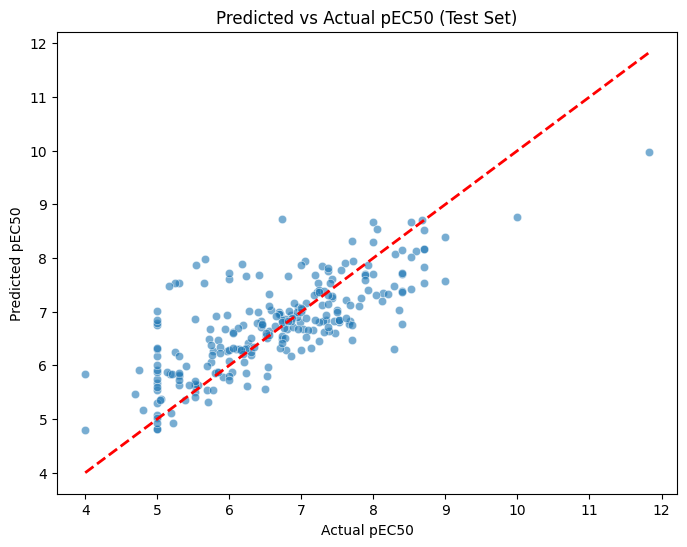

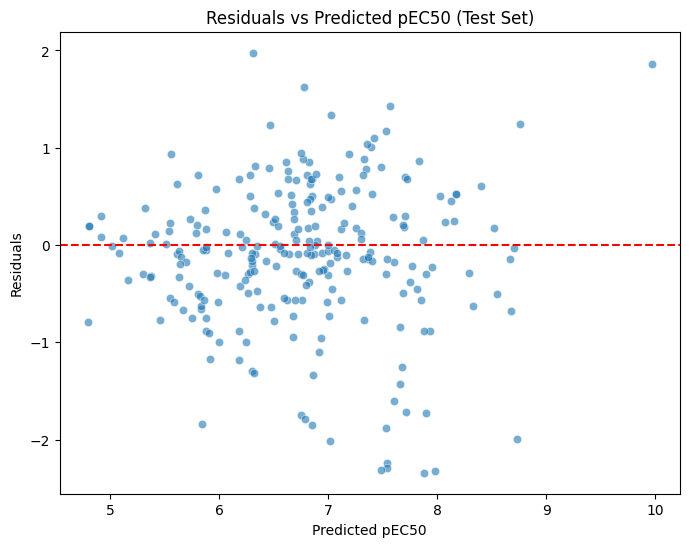

In [13]:
# Train and evaluate model
print("Training and evaluating model...")
model, X_test, y_test, y_pred_test = train_and_evaluate_model(X, y)

In [14]:
# Save the model
print("Saving the model...")
joblib.dump(model, 'pparg_drug_discovery_model.pkl')
print("Model saved as 'pparg_drug_discovery_model.pkl'")

Saving the model...
Model saved as 'pparg_drug_discovery_model.pkl'


In [15]:
# Save processed data
df.to_csv('processed_pparg_data.csv', index=False)
print("Processed data saved as 'processed_pparg_data.csv'")

Processed data saved as 'processed_pparg_data.csv'


In [16]:
# Predict pEC50 for new compounds
model = joblib.load('pparg_drug_discovery_model.pkl')

def generate_fingerprint(smiles):
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = morgan_gen.GetFingerprint(mol)
            return np.array(fp)
        return np.zeros(2048)
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return np.zeros(2048)

new_smiles = [
    'CC(/C=C/C(F)=C(/C)c1cc(C(C)(C)C)cc(C(C)(C)C)c1OCC(F)F)=C\C(=O)O',
    'CC(C)OC(Cc1ccc(OCCc2noc(-c3ccccc3)n2)cc1)C(=O)O'
]

print("Generating fingerprints for new compounds...")
X_new = np.array([generate_fingerprint(smiles) for smiles in new_smiles])
predictions = model.predict(X_new)

for smiles, pec50 in zip(new_smiles, predictions):
    ec50_nm = 10 ** (-pec50) * 1e9
    print(f"SMILES: {smiles}")
    print(f"Predicted pEC50: {pec50:.4f}")
    print(f"Predicted EC50 (nM): {ec50_nm:.4f}\n")

Generating fingerprints for new compounds...
SMILES: CC(/C=C/C(F)=C(/C)c1cc(C(C)(C)C)cc(C(C)(C)C)c1OCC(F)F)=C\C(=O)O
Predicted pEC50: 7.0464
Predicted EC50 (nM): 89.8576

SMILES: CC(C)OC(Cc1ccc(OCCc2noc(-c3ccccc3)n2)cc1)C(=O)O
Predicted pEC50: 7.5980
Predicted EC50 (nM): 25.2321



In [ ]:
               +----------------------------+
               |   QSAR Model Pipeline      |
               +----------------------------+
                        |
     +------------------+------------------+
     |                                     |
+-------------+                   +------------------+
| Data Loading|                   | Feature Generation|
| & Preprocessing|               +------------------+
+--------------+                        |
         |                            |
+------------------+        +--------------------------+
| Model Training & |        | Model & Data Saving     |
| Evaluation       |        +--------------------------+
+------------------+                        |
                                         |
                           +----------------------------+
                           | Prediction for New         |
                           | Compounds                  |
                           +----------------------------+